In [1]:
import jax
# jax.config.update("jax_default_device",jax.devices()[1])
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit,grad,jacfwd,jacrev,vmap
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from jax.scipy.linalg import solve
from EquationModel import OperatorPDEModel,CholInducedRKHS
from plotting import plot_obs,plot_compare_error
from evaluation_metrics import get_nrmse,table_u_errors
from data_utils import (
    get_xy_grid_pairs,
    GP_sampler,
    build_xy_grid,
    sample_xy_grid_latin,
    build_input_observations,
    build_u_obs_single,
    build_u_obs_all,
    sample_multiple_xy_grids_latin
)

from Kernels import (
    get_gaussianRBF,
    get_centered_scaled_poly_kernel
)
from jax.random import PRNGKey as pkey


In [18]:
xy_pairs = get_xy_grid_pairs(50,0,1,0,1)

# Sample m training functions from a GP
m = 10
kernel_GP = get_gaussianRBF(0.5)
u_true_functions = tuple(GP_sampler(num_samples = m,
                                        X = xy_pairs, 
                                        kernel = kernel_GP,
                                        reg = 1e-12,
                                        seed = 2024
                                    )
                                    )

# Permeability field A
def A(xy):
    x = xy[0]
    y = xy[1]
    return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

# Compute f = Pu for any u
def get_rhs_darcy(u):
    def Agradu(xy):
        return A(xy)*jax.grad(u)(xy)
    def Pu(xy):
        return jnp.trace(jax.jacfwd(Agradu)(xy))
    return Pu

# Lists of m true u's and f's
vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed

In [41]:
# Define the num of ghost points for each u
num_grid_points = 10
num_interior_points = 50
# # Ghost grid - Same per function
# xy_int,xy_bdy = build_xy_grid([0,1],[0,1],num_grid_points,num_grid_points)
# xy_all = jnp.vstack([xy_bdy,xy_int])
# xy_int,xy_bdy = sample_xy_grid_latin(36,[0,1],[0,1],8,8,seed = 120)
# xy_all = jnp.vstack([xy_bdy,xy_int])



xy_ints,xy_bdys = sample_multiple_xy_grids_latin(
        num_functions = m,
        num_interior = num_interior_points,
        x_range = [0,1],
        y_range = [0,1],
        num_grid_x_bdy = num_grid_points,
        num_grid_y_bdy = num_grid_points,
        key = pkey(23)
    )
xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_ints,xy_bdys))

# Number of observed points per u
num_obs = [2]*m

xy_obs,u_obs = build_u_obs_all(
    num_obs,
    xy_ints,
    xy_bdys,
    vmapped_u_true_functions,
    pkey(5)
)

# Define fine grid to plot
num_fine_grid = 100
x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid),np.linspace(0,1,num_fine_grid))
xy_fine = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

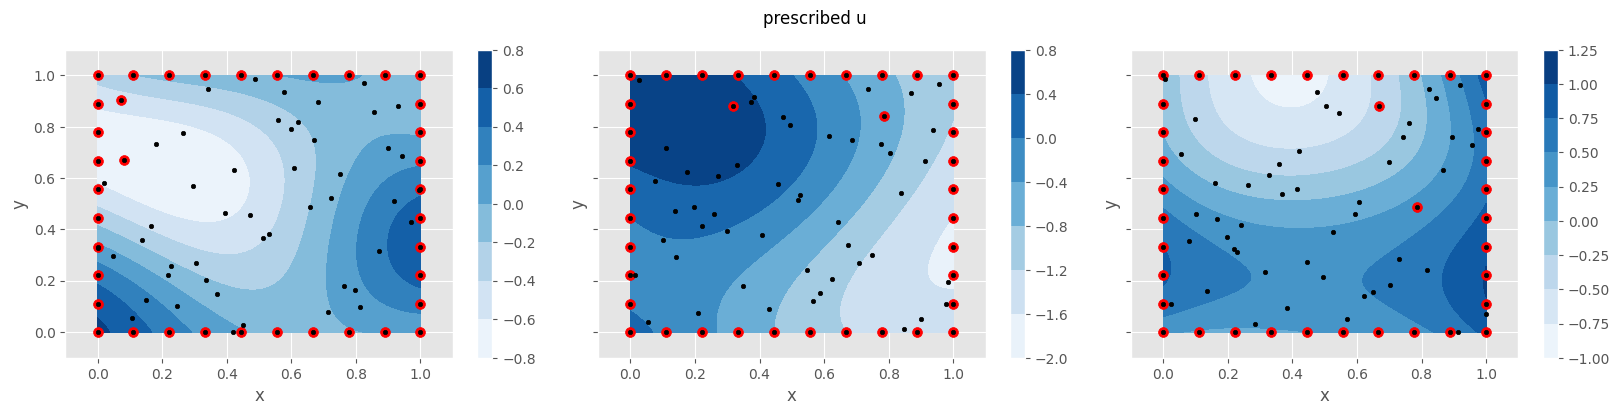

In [42]:
# Plot u's
plot_obs(xy_fine, xy_all, xy_obs, vmapped_u_true_functions, title = 'prescribed u')

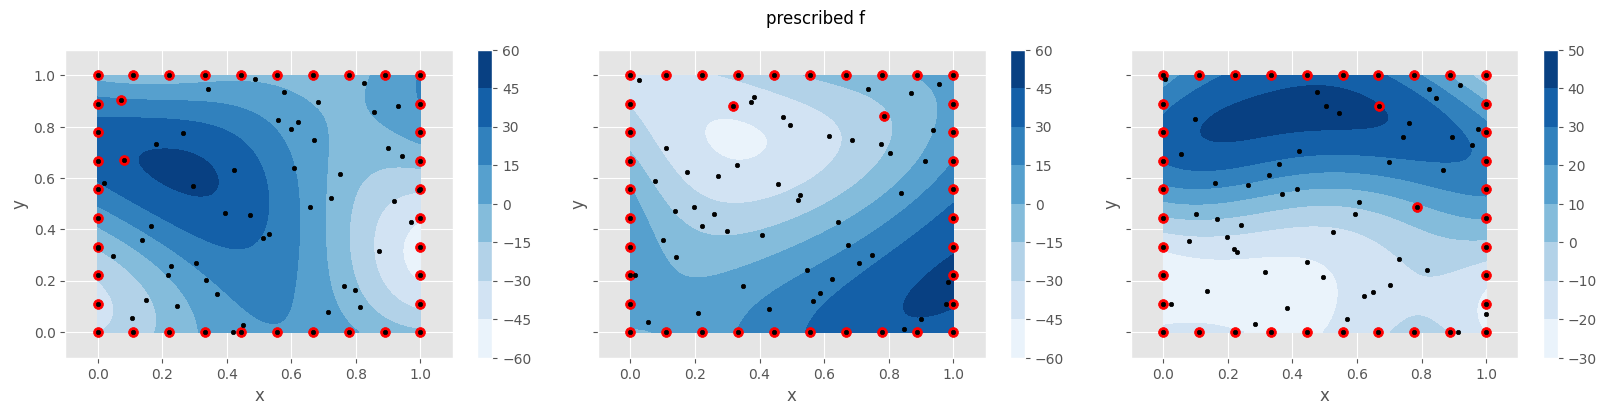

In [43]:
# Plot f's
plot_obs(xy_fine, xy_all, xy_obs, rhs_functions, title = 'prescribed f')

In [44]:
# Build operator features
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

In [45]:
# Build interpolants for u's
k_u = get_gaussianRBF(0.5)
u_models = tuple([CholInducedRKHS(
    xy_all[i],
    feature_operators,
    k_u
    ) for i in range(m)])

In [46]:
# Get necessary tuples
observation_points = tuple(xy_obs)
observation_values = tuple(u_obs)
collocation_points = xy_ints

rhs_values = tuple(rhs_func(xy_int) for xy_int,rhs_func in zip(xy_ints,rhs_functions))

all_u_params_init = tuple([
    model.get_fitted_params(obs_loc,obs_val)
    for obs_loc,obs_val,model in zip(observation_points,observation_values,u_models)])

grid_features_u_init = jnp.vstack([(
    model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        ) for xy_int,model,model_params in zip(xy_ints,u_models,all_u_params_init) ])


k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init,c=1)
k_P_x_part = get_gaussianRBF(0.4)
def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
 

class P_model():

    kernel_function = jit(
        get_kernel_block_ops(k_P,[eval_k],[eval_k])
    )

    num_params = len(grid_features_u_init)

    @jit
    def predict(input_data,params):
        K = P_model.kernel_function(input_data,input_data)
        return K@params
    
    def get_P_eval(input_data,params):
        def predict(prediction_points):
            K = P_model.kernel_function(prediction_points,input_data)
            return K@params
        return predict

In [47]:
collocation_points = xy_ints
EqnModel  = OperatorPDEModel(
    P_model,
    u_models,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_values,
    datafit_weight = 5.,
)

In [48]:
import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize
params_init = jnp.hstack(list(all_u_params_init)+[jnp.zeros(m*len(xy_ints[0]))])

params,loss_vals,JtRes,improvement_ratios,alpha_vals,iterate_history = LevenbergMarquadtMinimize(
    params_init.copy(),
    EqnModel,
    beta = 1e-8,
    max_iter = 301,
    init_alpha=3,
    line_search_increase_ratio=2.
)

  0%|          | 0/301 [00:00<?, ?it/s]

Iteration 0, loss = 270.8, Jres = 521.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 50.51, Jres = 401.5, alpha = 2.083, improvement_ratio = 1.135
Iteration 2, loss = 17.28, Jres = 303.3, alpha = 1.736, improvement_ratio = 0.9994
Iteration 3, loss = 10.15, Jres = 32.64, alpha = 1.447, improvement_ratio = 1.034
Iteration 4, loss = 7.017, Jres = 21.06, alpha = 1.206, improvement_ratio = 1.027
Iteration 5, loss = 5.271, Jres = 13.58, alpha = 1.005, improvement_ratio = 1.019
Iteration 50, loss = 0.002741, Jres = 0.3609, alpha = 0.0002747, improvement_ratio = 0.816
Iteration 100, loss = 3.705e-05, Jres = 0.0255, alpha = 1.032e-05, improvement_ratio = 0.8099
Iteration 150, loss = 1.564e-05, Jres = 0.006362, alpha = 1.666e-06, improvement_ratio = 0.7791
Iteration 200, loss = 1.442e-05, Jres = 0.0004524, alpha = 8.333e-07, improvement_ratio = 0.9654
Iteration 250, loss = 1.434e-05, Jres = 5.847e-05, alpha = 8.333e-07, improvement_ratio = 0.9952
Iteration 300, loss = 1.433e-05, Jre

  0%|          | 0/1000 [00:00<?, ?it/s]

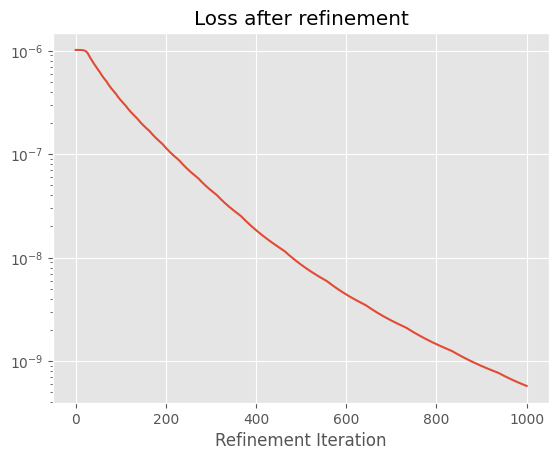

In [49]:
from LM_Solve import adaptive_refine_solution

p_adjusted,refinement_losses,reg_sequence = adaptive_refine_solution(params,EqnModel,1e-1,1000)

plt.plot(refinement_losses)
plt.xlabel("Refinement Iteration")
plt.title("Loss after refinement")
plt.yscale('log')

In [57]:
u_sols = EqnModel.get_u_params(p_adjusted)
P_sol = EqnModel.get_P_params(p_adjusted)
params
u_sols = EqnModel.get_u_params(params)
P_sol = EqnModel.get_P_params(params)


## Measures of accuracy for u's

Results for u_1


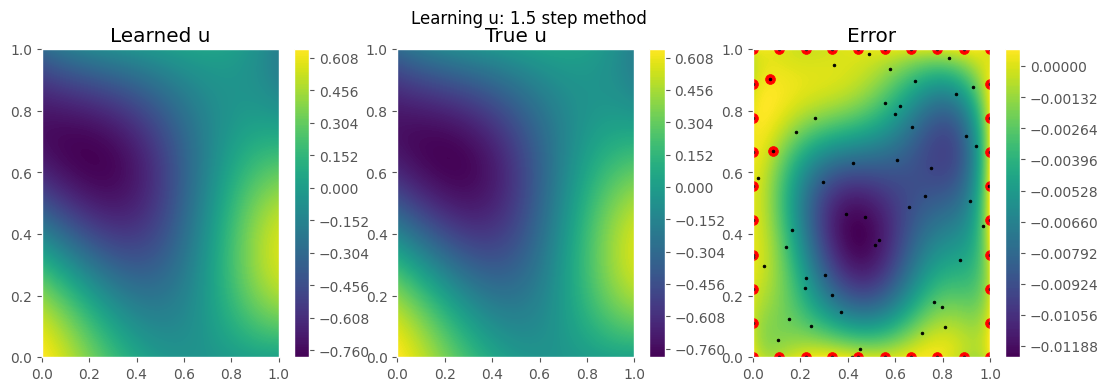

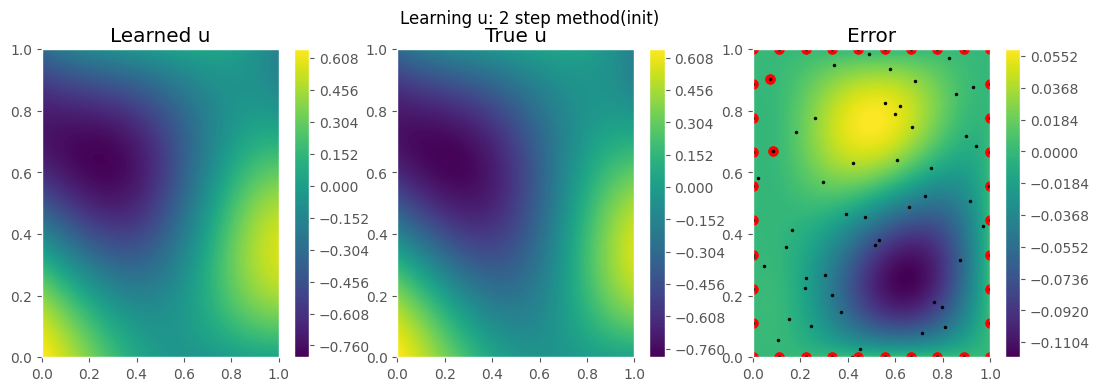

Results for u_2


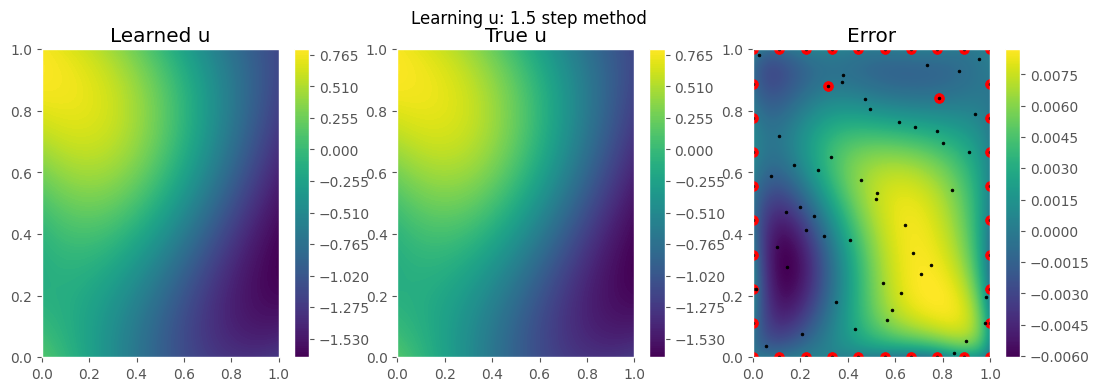

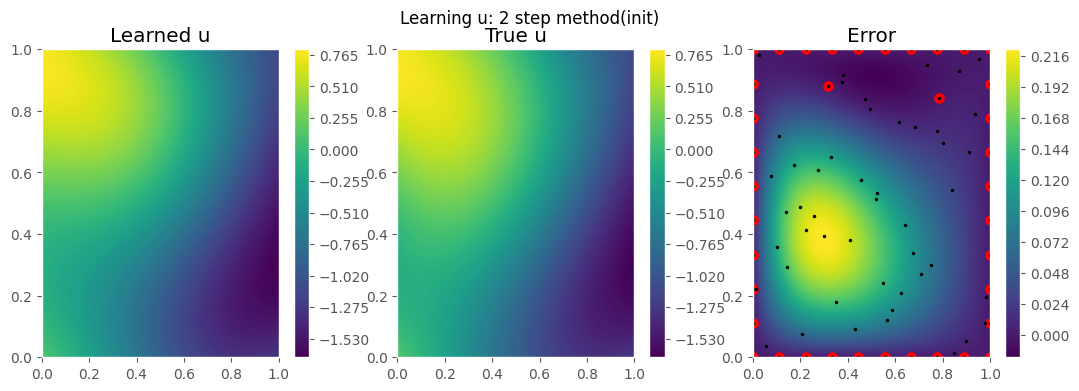

Results for u_3


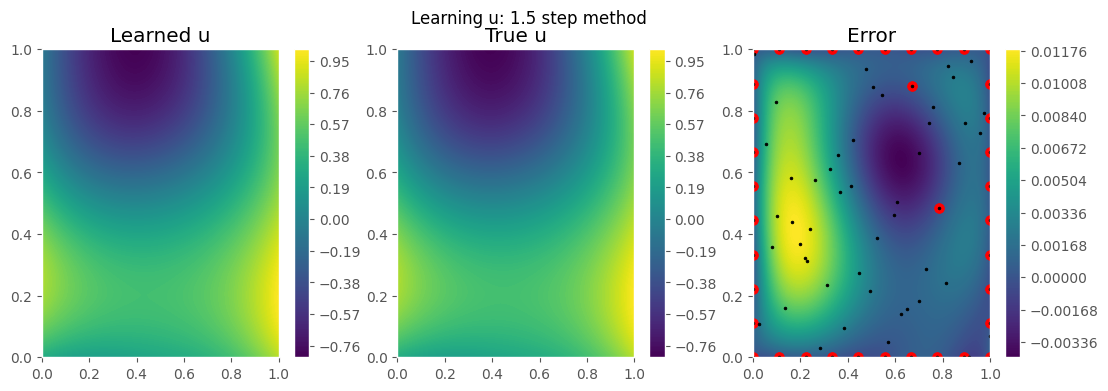

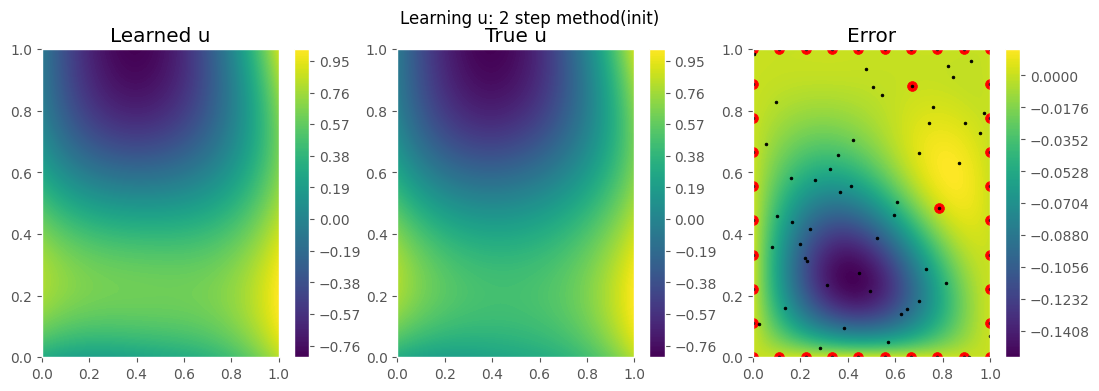

In [58]:
# Compare u's
# for i in range(len(u_true_functions)):
for i in range(3):
    print(f"Results for u_{i+1}")
    # Plot 
    plot_compare_error(xy_fine,
                       xy_all[i],
                       xy_obs[i],
                    lambda x:u_models[i].point_evaluate(x,u_sols[i]),
                    vmapped_u_true_functions[i]
                    , title = 'Learning u: 1.5 step method')
    plot_compare_error(xy_fine,
                       xy_all[i],
                       xy_obs[i],
                    lambda x:u_models[i].point_evaluate(x,all_u_params_init[i]),
                    vmapped_u_true_functions[i]
                    , title = 'Learning u: 2 step method(init)')

In [59]:
table_u_errors(
    xy_fine, u_models, u_sols, 
    vmapped_u_true_functions, 
    all_u_params_init)

,1 step,2 step (at initialization)
0,1.531404,11.218084
1,0.538301,11.484648
2,0.961989,12.177149
3,0.411830,1.777160
4,0.210177,4.866182
5,0.252554,5.033059
6,0.896201,3.470605
7,0.449239,1.568810
8,0.153492,3.974864
9,1.290576,11.232389


## Measures of accuracy for P

Auxiliar elements for evaluation

In [60]:
# Testing grid
num_fine_grid = 50
x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
xy_fine_int = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

# Estimated P from 1.5 step method
model_grid_features_all = EqnModel.get_stacked_eqn_features(u_sols)    
S_train = model_grid_features_all
P_func = P_model.get_P_eval(S_train,P_sol)

# Estimated P from 2 step method
init_P_features = EqnModel.get_stacked_eqn_features(all_u_params_init)
S_train_2 = init_P_features 
K = P_model.kernel_function(S_train_2,S_train_2)
P_params_naive = solve(K+1e-5*diagpart(K),EqnModel.stacked_collocation_rhs)
P_func2 = P_model.get_P_eval(S_train_2,P_params_naive)

# P[\phi(w)](fine_grid)
def evaluate_hatP(P_func, w, fine_grid, feature_operators):

    # Build S_test
    w_features = jnp.array([jax.vmap(operator(w,0))(xy_fine_int) for operator in feature_operators]).T
    model_fine_features = jnp.hstack([fine_grid, w_features])
    S_test = model_fine_features


    #P_preds_model_features = P_model.kernel_function(S_test,S_train)@P_sol 
    P_preds = P_func(S_test)
    return P_preds

### In sample error

In [61]:
# Error at m training functions

# Get list of approximated functions ^U = [^u_1, ^u_2, ^u_3]
true = [f(xy_fine_int) for f in rhs_functions]

u_approx_funcs = [u_models[ind].get_eval_function(u_sols[ind]) 
                  for ind in range(m)]
pred1_5 = [
    evaluate_hatP(
    P_func,
    u, xy_fine_int,feature_operators) for u in u_approx_funcs
]

twostep_u_approx_funcs = [u_models[ind].get_eval_function(all_u_params_init[ind]) 
                  for ind in range(m)]
pred2 = [
    evaluate_hatP(
    P_func2,
    u, xy_fine_int,feature_operators) for u in twostep_u_approx_funcs
]
rmses1_5 = jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)])
rmses2 = jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)])
print("Average error at training functions for 1.5 step: %", round(100*jnp.mean(rmses1_5),3))
print("Average error at training functions for 2 step: %", round(100*jnp.mean(rmses2),3))

Average error at training functions for 1.5 step: % 0.212
Average error at training functions for 2 step: % 19.31


### Out of sample error

In [63]:
# Error at M testing functions
M = 50
kernel_GP = get_gaussianRBF(0.5)
# Sample M test functions from GP(0,K)
w_test_functions = GP_sampler(num_samples = M,
                kernel = kernel_GP,
                X = xy_pairs, 
                reg = 1e-12,
                seed = 2025
                )
vmapped_w_test_functions = tuple([jax.vmap(w) for w in w_test_functions]) # vmap'ed
w_rhs_functions = tuple([jax.vmap(get_rhs_darcy(w)) for w in w_test_functions]) #vmap'ed

# mean 
true = [f_w(xy_fine_int) for f_w in w_rhs_functions]
#pred = [evaluate_hatP(w, xy_fine_int, u_sols, P_sol,feature_operators) for w in w_test_functions]
pred1_5 = [
    evaluate_hatP(
    lambda x:P_model.kernel_function(x,S_train)@P_sol,
    w, xy_fine_int,feature_operators) for w in w_test_functions
]

pred2 = [
    evaluate_hatP(
    P_func2,
    u, xy_fine_int,feature_operators) for u in w_test_functions
]

rmses1_5 = jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)])
rmses2 = jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)])
print("Average error at testing functions for 1.5 step: %", round(100*jnp.mean(rmses1_5),2))
print("Average error at testing functions for 2 step: %", round(100*jnp.mean(rmses2),2))

Average error at testing functions for 1.5 step: % 4.3100000000000005
Average error at testing functions for 2 step: % 33.54


### Operator learning error

In [ ]:
# Create P model that uses P from 1.5
def equation_Model(P_model, new_rhs):
    return 0

# Create Levenberg-Marquad 

def solve_pde(P_model, new_rhs):
    return 0

In [ ]:
# Index of the function to evaluate
eval_ind = 2
# Select u_2 of index eval_ind
eval_model = u_models[eval_ind] # Induced_RKHS object
# Select trained dual coefficients alphas_2 
eval_sol = u_sols[eval_ind] # where u(.) = alphas_2^T k_u(.,train_set)


# Create the test fine grid (interior): X_fine
num_fine_grid = 50
x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
xy_fine_int = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

# Evaluate u_2 at the test fine grid
# u_true_interior = u_true_function1(xy_fine_int) Not being used

########### 1.5 STEP METHOD

#### GET S_TRAIN
# Get the stacked features AFTER TRAINING from u_0,u_1,u_2, i.e., [X_train_all, U(X_train_all), DU(X_train_all)] where U = [u_1,u_2,u_3] and X_train_all = [X_train1, X_train2, X_train3]
model_grid_features_all = EqnModel.get_stacked_eqn_features(u_sols)

#### GET S_TEST
# Evaluate u_2 on the test grid using alphas_2
# model_fine_features_u = eval_model.evaluate_operators(feature_operators,xy_fine_int,eval_sol).reshape(len(xy_fine_int),len(feature_operators),order = 'F')
# get array [u_2(X_fine), D u_2(X_fine)] for u_2
evaluation_u = eval_model.evaluate_operators(feature_operators,xy_fine_int,eval_sol)
# Reshape evaluation_u
grid_features_u = evaluation_u.reshape(len(xy_fine_int),len(feature_operators),order = 'F')
# Stack grid_features_u with X_fine to get S_TEST = [X_fine u_2(X_fine) Du_2(X_fine)]
model_fine_features = jnp.hstack([xy_fine_int,grid_features_u])

### GET P(S_TEST)
# Evaluate P_1.5 at S_TEST 
P_preds_model_features = P_model.kernel_function(model_fine_features,model_grid_features_all)@P_sol 


############# 2 STEP METHOD


# GET S_TRAIN
# Get the stacked features BEFORE TRAINING from u_0,u_1,u_2, i.e., [X_init_all, U(X_init_all), DU(X_init_all)] where U = [u_1,u_2,u_3] and X_init_all = [X_init1, X_init2, X_init3]
init_P_features = EqnModel.get_stacked_eqn_features(all_u_params_init)

# K(S_train,S_train) where S_train is done from the 2-step method
K = P_model.kernel_function(init_P_features,init_P_features)
# Get alphas for P_2 (perform Kernel ridge regression) 
P_params_naive = solve(K+1e-5*diagpart(K),EqnModel.stacked_collocation_rhs)

### Get S_TEST
# init_fine_features_u = eval_model.evaluate_operators(feature_operators,xy_fine_int,all_u_params_init[eval_ind]).reshape(len(xy_fine_int),len(feature_operators),order = 'F')
evaluation_u = eval_model.evaluate_operators(feature_operators,xy_fine_int,all_u_params_init[eval_ind])
grid_features_u = evaluation_u.reshape(len(xy_fine_int),len(feature_operators),order = 'F')
init_fine_features = jnp.hstack([xy_fine_int,grid_features_u])

P_preds_init_model_features_init = P_model.kernel_function(init_fine_features,init_P_features)@P_params_naive


####
print("1.5 step optimized model feature predictions: %",round(100*get_nrmse(rhs_functions[eval_ind](xy_fine_int),P_preds_model_features),2))
print("2 step model feature predictions %",round(100*get_nrmse(rhs_functions[eval_ind](xy_fine_int),P_preds_init_model_features_init),2))

1.5 step optimized model feature predictions: % 10.69
2 step model feature predictions % 32.93
